# <center>Subitization Model</center>

### Calling Dependencies

In [2]:
import nest
import matplotlib.pyplot as plt
import numpy as np


              -- N E S T --
  Copyright (C) 2004 The NEST Initiative

 Version: 3.6.0
 Built: Mar  7 2024 11:55:11

 This program is provided AS IS and comes with
 NO WARRANTY. See the file LICENSE for details.

 Problems or suggestions?
   Visit https://www.nest-simulator.org

 Type 'nest.help()' to find out more about NEST.



### Understanding the Integrate and Fire Model Used in Nest Simulator

The following code will be used for testing the ```iaf_psc_alpha model``` given by nest simulator. This is a leaky integrate-and-fire model with alpha shaped input currents. It is a leaky integrate and fire neuron model with:
* a hard threshold
* a fixed refractory period
* no adaptation mechanism
* $\alpha$-shaped synaptic input currents.

#### Explanation of iaf_psc_alpha code

**The ```integrate and fire model```:**

$\tau_{\text{m}}\frac{dV_\text{m}}{dt} = -(V_{\text{m}} - E_\text{L})+ RI$

where:\
&emsp;$ I = I_{\text{syn}} + I_\text{e}$\
&emsp;$ I_{\text{syn}}$ &rarr; input current from pre-synaptic neurons\
&emsp;$I_\text{e}$ &rarr; constant input current\
&emsp;$R$ &rarr; resistance of the circuit\
&emsp;$V_\text{m}$ &rarr; membrance potential \
&emsp;$E_\text{L}$ &rarr; resting membrance potential\
&emsp;$\tau_{\text{m}}$ &rarr; membrane decay constant


A spike is emitted at timestep $t^*=t_{k+1}$ if:

$V_\text{m}(t_k) < V_{th} \quad\text{and}\quad V_\text{m}(t_{k+1})\geq V_\text{th} \;$

This membrane potential will be clamped to $V_{\text{reset}} where the refractory period is defined as $t_{\text{ref}}$:\
$V_\text{m}(t) = V_{\text{reset}} \quad\text{for}\quad t^* \leq t < t^* + t_{\text{ref}} \;,$

**Calculating the Synaptic Input, $I_{\text{syn}}$:**

$I_{\text{syn}}(t) = I_{\text{syn, ex}}(t) + I_{\text{syn, in}}(t)$

and

$I_{\text{syn, X}}(t) = \sum_{j} w_j \sum_k i_{\text{syn, X}}(t-t_j^k-d_j) \;,$

where:\
&emsp;$ I_{\text{syn, ex}}(t)$ &rarr; excitatory synaptic input\
&emsp;$ I_{\text{syn, in}}(t)$ &rarr; inhibitory synaptic input\
&emsp;$ j$ &rarr; $j$ is used to define for $\text{X}$ ($\text{X} \in \{I_{\text{syn, ex}}, I_{\text{syn, in}}(t)\}$)\
&emsp;$ k$ &rarr; indexes the spikes times of pre-synaptic neuron $j$\
&emsp;$ d_j$ &rarr; delay from pre-synaptic neuron $j$

**The post-synaptic currents are given by:**

$i_{\text{syn, X}}(t) = \frac{e}{\tau_{\text{syn, X}}} t e^{-\frac{t}{\tau_{\text{syn, X}}}} \Theta(t)$

where:\
&emsp;$Theta(t)$ &rarr; the heaviside step function. The PSCs are normalized to unit maximum, i.e., $i_{\text{syn, X}}(t= \tau_{\text{syn, X}}) = 1 \;.$

As a consequence, the total charge $q$ transferred by a single PSC depends on the synaptic time constant according to

$q = \int_0^{\infty}  i_{\text{syn, X}}(t) dt = e \tau_{\text{syn, X}} \;.$

By default, $V_\text{m}$ is not bounded from below. To limit
hyperpolarization to biophysically plausible values, set parameter
$V_{\text{min}}$ as lower bound of $V_\text{m}$.

#### Initializing Nest and Connections


Mar 20 19:24:01 NodeManager::prepare_nodes [Info]: 
    Preparing 72 nodes12
 for simulation.

Mar 20 19:24:01 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 72
    Simulation time (ms): 1000
    Number of OpenMP threads: 1
    Number of MPI processes: 1

Mar 20 19:24:01 SimulationManager::run [Info]: 
    Simulation finished.


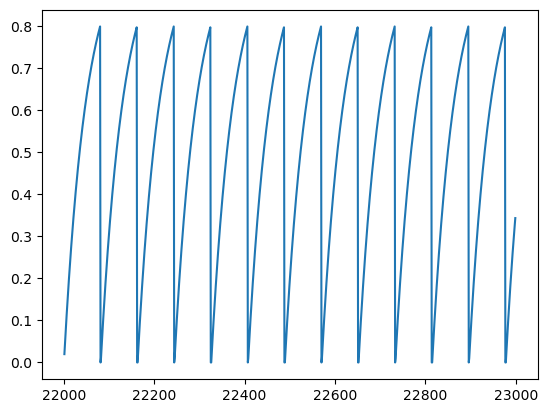

In [28]:
parameters = {
        "V_m": 0,                   # mV
        "E_L": 0,                   # mV
        "V_th": 0.8,                # mV
        "V_reset": 0,               # mV
        "tau_syn_ex": 1000,         # ms rise time of the excitatory synaptic alpha function (i.e. to see the current for each spike decays)
        "I_e": 1 * (10**12),        # pA input current
        "tau_m": 50,                # ms membrane time constant
        "C_m": (50) * 10**12,       # pF membrane capacitance (calculated for R = 1)
        "t_ref": 1                  # ms refractory period
    }

neuron = nest.Create('iaf_psc_alpha', params=parameters)
spike_recorder = nest.Create('spike_recorder')
multimeter = nest.Create('multimeter')
multimeter.set(record_from=["V_m"])

nest.Connect(multimeter, neuron)
nest.Connect(neuron, spike_recorder)
nest.Simulate(1000)

dmm = multimeter.get()
Vms = dmm["events"]["V_m"]
ts = dmm["events"]["times"]
events = spike_recorder.get("events")
senders = events["senders"]
print(len(senders))
plt.figure(1)
plt.plot(ts,Vms)
plt.show()